# What should a team do in order to go to the play-offs?

<a id='toc'></a>
## Table of Contents

<ul>
<li><a href="#toc">Table of Contents</a></li>
<li><a href="#importp">Import Packages</a></li>
<li><a href="#importd">Import Dataset</a></li>
<li><a href="#dtid">Data Tidying</a></li>
<li><a href="#maptime">Mapping Time!</a></li>
</ul>

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns

%matplotlib inline

In [46]:
df = pd.read_csv('Data/baseball.csv')

In [47]:
df = df[df['Year'] < 2002]

In [48]:
df['RD'] = df['RS'] - df['RA']

In [49]:
df.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG,RD
330,ANA,AL,2001,691,730,75,0.327,0.405,0.261,0,NaN,NaN,162,0.331,0.412,-39
331,ARI,NL,2001,818,677,92,0.341,0.442,0.267,1,5.0,1.0,162,0.311,0.404,141
332,ATL,NL,2001,729,643,88,0.324,0.412,0.260,1,7.0,3.0,162,0.314,0.384,86
333,BAL,AL,2001,687,829,63,0.319,0.380,0.248,0,NaN,NaN,162,0.337,0.439,-142
334,BOS,AL,2001,772,745,82,0.334,0.439,0.266,0,NaN,NaN,161,0.329,0.393,27


In [50]:
df.isnull().sum()

Team              0
League            0
Year              0
RS                0
RA                0
W                 0
OBP               0
SLG               0
BA                0
Playoffs          0
RankSeason      748
RankPlayoffs    748
G                 0
OOBP            812
OSLG            812
RD                0
dtype: int64

## Create a visualization of how variables behave

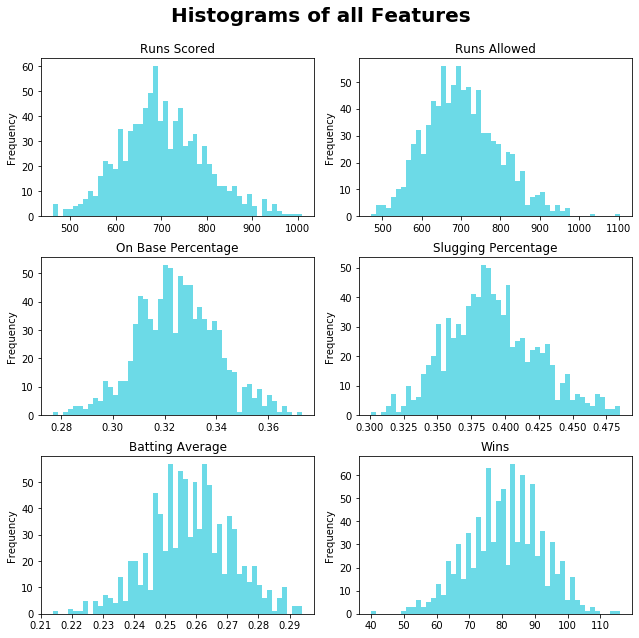

In [51]:
fig = plt.figure(figsize=(9, 9))
gspec = fig.add_gridspec(3,2)

ax1 = fig.add_subplot(321)
df['RS'].plot(
    kind='hist',
    bins=50,
    title='Runs Scored')

ax2 = fig.add_subplot(322)
df['RA'].plot(
    kind='hist', 
    bins=50,
    title='Runs Allowed')

ax3 = fig.add_subplot(323)
df['OBP'].plot(
    kind='hist', 
    bins=50,
    title='On Base Percentage')

ax4 = fig.add_subplot(324)
df['SLG'].plot(
    'hist', 
    bins=50,
    title='Slugging Percentage')

ax5 = fig.add_subplot(325)
df['BA'].plot(
    kind='hist', 
    bins=50,
    title='Batting Average')

ax6 = fig.add_subplot(326)
df['W'].plot(
    kind='hist', 
    bins=50,
    title='Wins')

plt.tight_layout()
fig.subplots_adjust(top=0.9)
fig.suptitle('Histograms of all Features', 
             weight='semibold',
             size=20);

In [52]:
means = df[df['Playoffs'] == 1].mean()

In [53]:
stds = df[df['Playoffs'] == 1].std()

In [54]:
min_W = means.W + stds.W
min_W

101.39866653570307

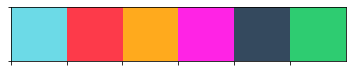

In [55]:
flatui = ["#6cdae7", "#fd3a4a", "#ffaa1d", "#ff23e5", "#34495e", "#2ecc71"]
sns.set_palette(flatui)
sns.palplot(sns.color_palette())

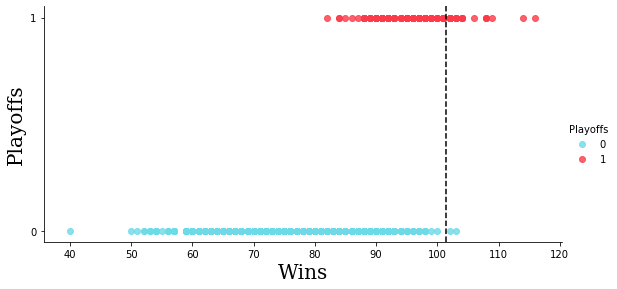

In [56]:
fontdict={'family': 'serif',
         'size': 20,
         'weight': 'medium'}
sns.lmplot(x='W', y='Playoffs',
          fit_reg=False,
          hue='Playoffs',
          data=df,
          aspect=2,
          height=4)
plt.xlabel("Wins", fontdict=fontdict)
plt.ylabel("Playoffs", fontdict=fontdict)
plt.yticks((0,1), [0, 1])
plt.axvline(min_W, 0, 
           color='Black',
           ls='--');

> Only twice, teams who had over 101 wins didn't make it to playoffs.

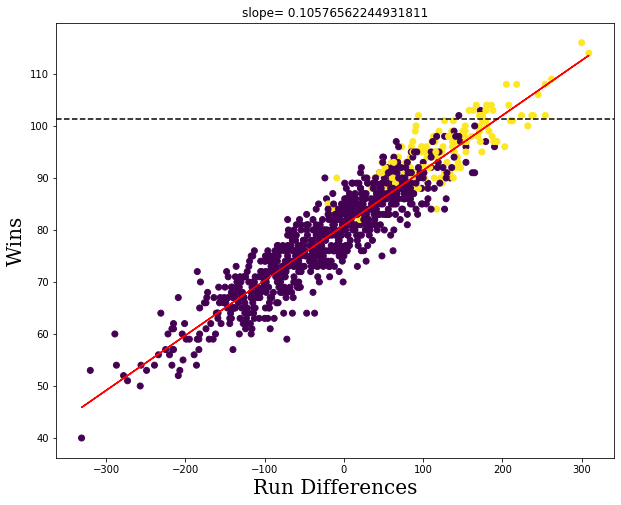

In [57]:
x = df.RD
y = df.W

slope, intercept = np.polyfit(x, y, 1)
abline_values = [slope * i + intercept for i in x]

plt.figure(figsize=(10, 8))
plt.scatter(x, y, c=df['Playoffs'])
plt.plot(x, abline_values, 'r')
plt.title('slope= %s' % (slope), fontsize = 12)

plt.xlabel("Run Differences", fontdict=fontdict)
plt.ylabel("Wins", fontdict=fontdict)
plt.axhline(min_W, 0, 1, color='k', ls='--');

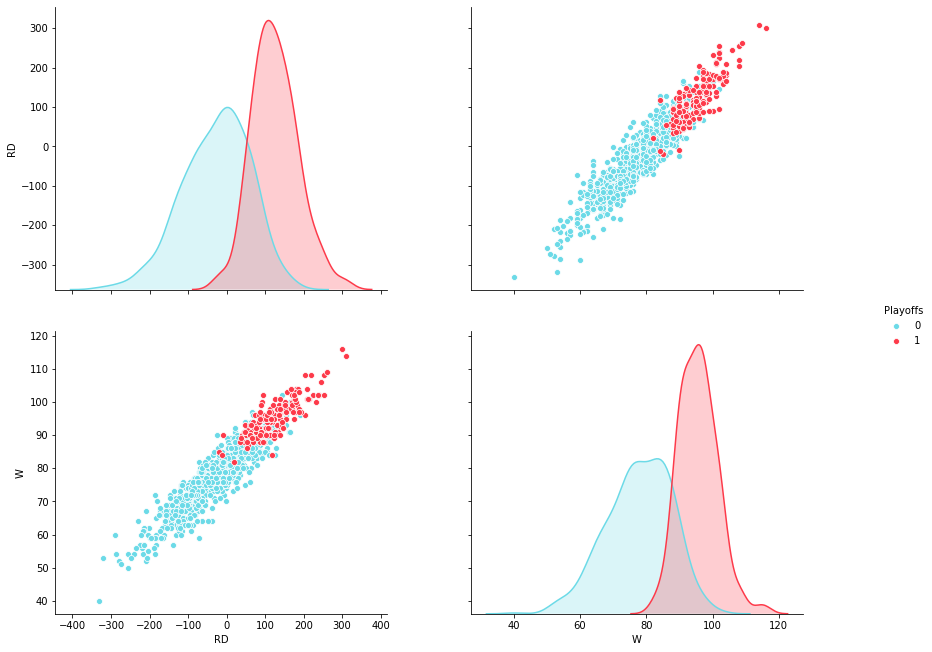

In [58]:
# Or use Seaborn instead
corrcheck = df[['RD', 'W', 'Playoffs']].copy()
g = sns.pairplot(corrcheck, hue = 'Playoffs',vars=["RD", "W"])
g.fig.set_size_inches(14,10);

In [59]:
df[['W', 'RD']].corr()

,W,RD
W,1.000000,0.938515
RD,0.938515,1.000000


> So friggin' strongly correlated! score more RS and suffer less RA in order to obtain more Ws!

`BUT HOW?`

In [60]:
df.columns

Index(['Team', 'League', 'Year', 'RS', 'RA', 'W', 'OBP', 'SLG', 'BA',
       'Playoffs', 'RankSeason', 'RankPlayoffs', 'G', 'OOBP', 'OSLG', 'RD'],
      dtype='object')

In [61]:
df[['RS', 'OBP', 'SLG', 'BA']].corr()

,RS,OBP,SLG,BA
RS,1.000000,0.904909,0.926384,0.831625
OBP,0.904909,1.000000,0.806154,0.854055
SLG,0.926384,0.806154,1.000000,0.814068
BA,0.831625,0.854055,0.814068,1.000000


In [62]:
df[['RA', 'OOBP', 'OSLG']].corr()
# We can infer similar relationship with RS

,RA,OOBP,OSLG
RA,1.000000,0.909908,0.895110
OOBP,0.909908,1.000000,0.796526
OSLG,0.895110,0.796526,1.000000


## Building The Regression Model

In [63]:
x = df[['OBP', 'SLG']].values
y = df[['RS']].values
# BA is dropped from x since it is suffers from multicollinearity (with slg)

RS_model = LinearRegression()

RS_model.fit(x, y)

RS_intercept = RS_model.intercept_[0]
RS_OBP_coef = RS_model.coef_[0,0]
RS_SLG_coef = RS_model.coef_[0,1]
RS_equation = 'RS = ' + str(round(RS_intercept, 2)) + ' + ' + str(round(RS_OBP_coef, 2)) + 'OBP' + ' + ' + str(round(RS_SLG_coef, 2)) + 'SLG'

print(RS_equation)

RS = -804.63 + 2737.77OBP + 1584.91SLG


In [64]:
dfdrop = df.dropna()
dfdrop.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG,RD
331,ARI,NL,2001,818,677,92,0.341,0.442,0.267,1,5.0,1.0,162,0.311,0.404,141
332,ATL,NL,2001,729,643,88,0.324,0.412,0.260,1,7.0,3.0,162,0.314,0.384,86
338,CLE,AL,2001,897,821,91,0.350,0.458,0.278,1,6.0,4.0,162,0.341,0.417,76
342,HOU,NL,2001,847,769,93,0.347,0.451,0.271,1,4.0,4.0,162,0.325,0.437,78
349,NYY,AL,2001,804,713,95,0.334,0.435,0.267,1,3.0,2.0,161,0.318,0.398,91


In [65]:
rax = dfdrop[['OOBP', 'OSLG']].values
ray = dfdrop[['RA']].values

RA_model = LinearRegression()

RA_model.fit(rax, ray)

RA_intercept = RA_model.intercept_[0]
RA_OOBP_coef = RA_model.coef_[0,0]
RA_OSLG_coef = RA_model.coef_[0,1]
RA_equation = 'RA = ' + str(round(RA_intercept, 2)) + ' + ' + str(round(RA_OOBP_coef, 2)) + 'OOBP' + ' + ' + str(round(RA_OSLG_coef, 2)) + 'OSLG'

print(RA_equation)

RA = -775.16 + 3225.0OOBP + 1106.5OSLG


In [75]:
wx = df[['RD']].values
wy = df[['W']].values

W_model = LinearRegression()

W_model.fit(wx, wy)

W_intercept = W_model.intercept_[0]
W_coef = W_model.coef_[0,0]
W_equation = 'W = ' + str(round(W_intercept, 2)) + ' + ' + str(round(W_coef, 2)) + 'W'

print(W_equation)

W = 80.88 + 0.11W


## Prediction

In [74]:
OBP2001 = df.loc[(df.Team == 'OAK') & (df.Year == 2001)].OBP.item()
SLG2001 = df.loc[(df.Team == 'OAK') & (df.Year == 2001)].SLG.item()

OOBP2001 = df.loc[(df.Team == 'OAK') & (df.Year == 2001)].OOBP.item()
OSLG2001 = df.loc[(df.Team == 'OAK') & (df.Year == 2001)].OSLG.item()

In [76]:
RSpred = RS_model.predict([[OBP2001, SLG2001]])
RApred = RA_model.predict([[OOBP2001, OSLG2001]])
RDpred = RSpred.item() - RApred.item()
Wpred = W_model.predict([[RDpred]])

In [85]:
print('Predicted run scores in 2001: ' + str(round(RSpred.item(), 2)))
print('Predicted run allowed in 2001: ' + str(round(RApred.item(), 2)))
print('Predicted run difference in 2001: ' + str(round(RDpred, 2)))
print('Predicted wins in 2001: ' + str(round(Wpred.item(), 2)))

Predicted run scores in 2001: 835.68
Predicted run allowed in 2001: 638.61
Predicted run difference in 2001: 197.07
Predicted wins in 2001: 101.72
